In [1]:
import os
os.environ['KERAS_BACKEND'] = 'theano'

In [2]:
import keras
from keras.layers import Convolution2D, Flatten, Dense, Input, Conv2DTranspose, BatchNormalization, Dropout
from keras.models import Model
from keras.regularizers import l2
import numpy as np
import keras.backend as K
K.image_dim_ordering()

Using Theano backend.


'tf'

In [3]:
os.sys.path.append('Pilot2/P2B1/fromRAY/')
os.sys.path.append('Pilot2/P2B1/')
import p2b1_mol_AE as p2b1
import helper as hf

In [4]:
def full_conv_mol_auto(bead_k_size=20, mol_k_size=12, weights_path=None, input_shape=(1, 784),
                       hidden_layers=None, nonlinearity='relu', l2_reg=0.0):

    input_img = Input(shape=input_shape)
    layer3_dim = input_shape[1]/(bead_k_size*mol_k_size)

    if hidden_layers!=None:

        if type(hidden_layers) != list:
            hidden_layers = list(hidden_layers)
        for i, l in enumerate(hidden_layers):
            if i == 0:
                encoded = Convolution2D(l, bead_k_size, strides=(1, bead_k_size), padding='same', 
                                        activation=nonlinearity, input_shape=input_shape, 
                                        kernel_regularizer=l2(l2_reg), 
                                        kernel_initializer='glorot_normal')(input_img)
                encoded = Dropout(0.75)(encoded)
                encoded = BatchNormalization()(encoded)
            elif i == 1:
                encoded = Convolution2D(l, mol_k_size, strides=(1, mol_k_size), padding='same', 
                                        activation=nonlinearity, kernel_regularizer=l2(l2_reg), 
                                        kernel_initializer='glorot_normal')(encoded)
                encoded = Dropout(0.75)(encoded)
                encoded = BatchNormalization()(encoded)
            elif i == 2:
                encoded = Convolution2D(l, 11, strides=(1, layer3_dim), padding='same', 
                                        activation=nonlinearity, kernel_regularizer=l2(l2_reg), 
                                        kernel_initializer='glorot_normal')(encoded)
                encoded = Dropout(0.75)(encoded)
                encoded = BatchNormalization()(encoded)
            else:
                encoded = Convolution2D(l, kernel_size=1, strides=1, padding='same', 
                                        activation=nonlinearity, kernel_regularizer=l2(l2_reg), 
                                        kernel_initializer='glorot_normal')(encoded)
                if i != len(hidden_layers) - 1:
                    encoded = Dropout(0.75)(encoded)
                encoded = BatchNormalization()(encoded)
                
                
 
        
        for i, l in reversed(list(enumerate(hidden_layers))):
            if i < len(hidden_layers)-1:
                if i == len(hidden_layers) - 2:
                    print "in first:", i
                    decoded = Conv2DTranspose(l, 1, strides=(1,1), padding='same',
                                              activation=nonlinearity, kernel_regularizer=l2(l2_reg), 
                                              kernel_initializer='glorot_normal')(encoded)
                    decoded = Dropout(0.75)(decoded)
                    decoded = BatchNormalization()(decoded)
                elif i < len(hidden_layers) - 2 and i > 1:
                    print "in second: ", i
                    decoded = Conv2DTranspose(l, 1, strides=(1,1), padding='same',
                                              activation=nonlinearity, kernel_regularizer=l2(l2_reg), 
                                              kernel_initializer='glorot_normal')(decoded)
                    decoded = Dropout(0.75)(decoded)
                    decoded = BatchNormalization()(decoded)
                elif i == 1:
                    print "in third: ", i
                    decoded = Conv2DTranspose(l, 1, strides=(1,layer3_dim), padding='same',
                                              activation=nonlinearity, kernel_regularizer=l2(l2_reg), 
                                              kernel_initializer='glorot_normal')(decoded)
                    decoded = Dropout(0.75)(decoded)
                    decoded = BatchNormalization()(decoded)
                else:
                    print "in else: ", i
                    decoded = Conv2DTranspose(l, 1, strides=(1,mol_k_size), padding='same',
                                              activation=nonlinearity, kernel_regularizer=l2(l2_reg), 
                                              kernel_initializer='glorot_normal')(decoded)
                    decoded = Dropout(0.75)(decoded)
                    decoded = BatchNormalization()(decoded)
 
        decoded = Conv2DTranspose(1, 1, strides=(1,bead_k_size), padding='same',
                                  activation=nonlinearity, kernel_regularizer=l2(l2_reg), 
                                  kernel_initializer='glorot_normal')(decoded)

    else:
        decoded = Dense(input_shape[1], kernel_regularizer=l2(l2_reg))(input_img)

    AE_model = Model(inputs=input_img, outputs=decoded)
    encoder_model = Model(inputs=input_img, outputs=encoded)
    
    if weights_path:
        print('Loading Model')
        model.load_weights(weights_path)
    return AE_model, encoder_model

In [42]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_train = x_train.reshape(x_train.shape[0],-1)
X = scaler.fit_transform(x_train)
print np.max(x_train), np.min(x_train)

data = np.load('Pilot2/common/generate_datasets/test_16_outof_29.npz')
X = data['features']
nbrs = data['neighbors']
X.shape


255 0


"data = np.load('Pilot2/common/generate_datasets/test_16_outof_29.npz')\nX = data['features']\nnbrs = data['neighbors']\nX.shape"

In [43]:
#X = x_train
X = X.reshape(X.shape[0], 1, -1, 1)
print X.shape
nbrs = 0
molecular_input_dim = X.shape[2]*X.shape[3]*(nbrs+1)
molecular_hidden_layers = [128, 64, 32, 16, 8]

'''mol_AE_model, mol_latent_model = full_conv_mol_auto(bead_k_size=8, mol_k_size=2,
                                                    weights_path=None, input_shape=(1, molecular_input_dim, 1),
                                                    nonlinearity='relu',
                                                    hidden_layers=molecular_hidden_layers)
'''
#mol_AE_model = p2b1.dense_auto(hidden_layers=molecular_hidden_layers)
X = X.reshape(X.shape[0], 1, -1)
y = X.reshape(X.shape[0], -1)
print X.shape
mol_AE_model = p2b1.conv_dense_auto(input_shape=(1, molecular_input_dim), hidden_layers=molecular_hidden_layers)

(60000, 1, 784, 1)
(60000, 1, 784)


In [44]:
mol_AE_model.compile(optimizer='adam', loss='mse', metrics=['mse'])
mol_AE_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 1, 784)            0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 1, 128)            802944    
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 1, 64)             65600     
_________________________________________________________________
conv1d_49 (Conv1D)           (None, 1, 32)             16416     
_________________________________________________________________
conv1d_50 (Conv1D)           (None, 1, 16)             4112      
_________________________________________________________________
conv1d_51 (Conv1D)           (None, 1, 8)              1032      
_________________________________________________________________
flatten_11 (Flatten)         (None, 8)                 0         
__________

In [11]:
np.max(X)

255

In [10]:
test_before = mol_latent_model.predict(X[0:1])
print np.squeeze(test_before)

[ 0.  0.  0.  0.  0.  0.  0.  0.]


In [49]:

for i in range(10):
    history = mol_AE_model.fit(X[:10000], y[:10000], epochs=1)

    '''print mol_latent_model.predict(X[0:1])
    print mol_latent_model.predict(X[45000:45001])
'''

Epoch 1/1
10000/10000 [==============================] - 25s - loss: 0.0563 - mean_squared_error: 0.0563     

In [53]:
out_1 = mol_AE_model.predict(X[0:1])
out_2 = mol_AE_model.predict(X[46000:46001])

import matplotlib as mpl
mpl.use('nbagg')
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


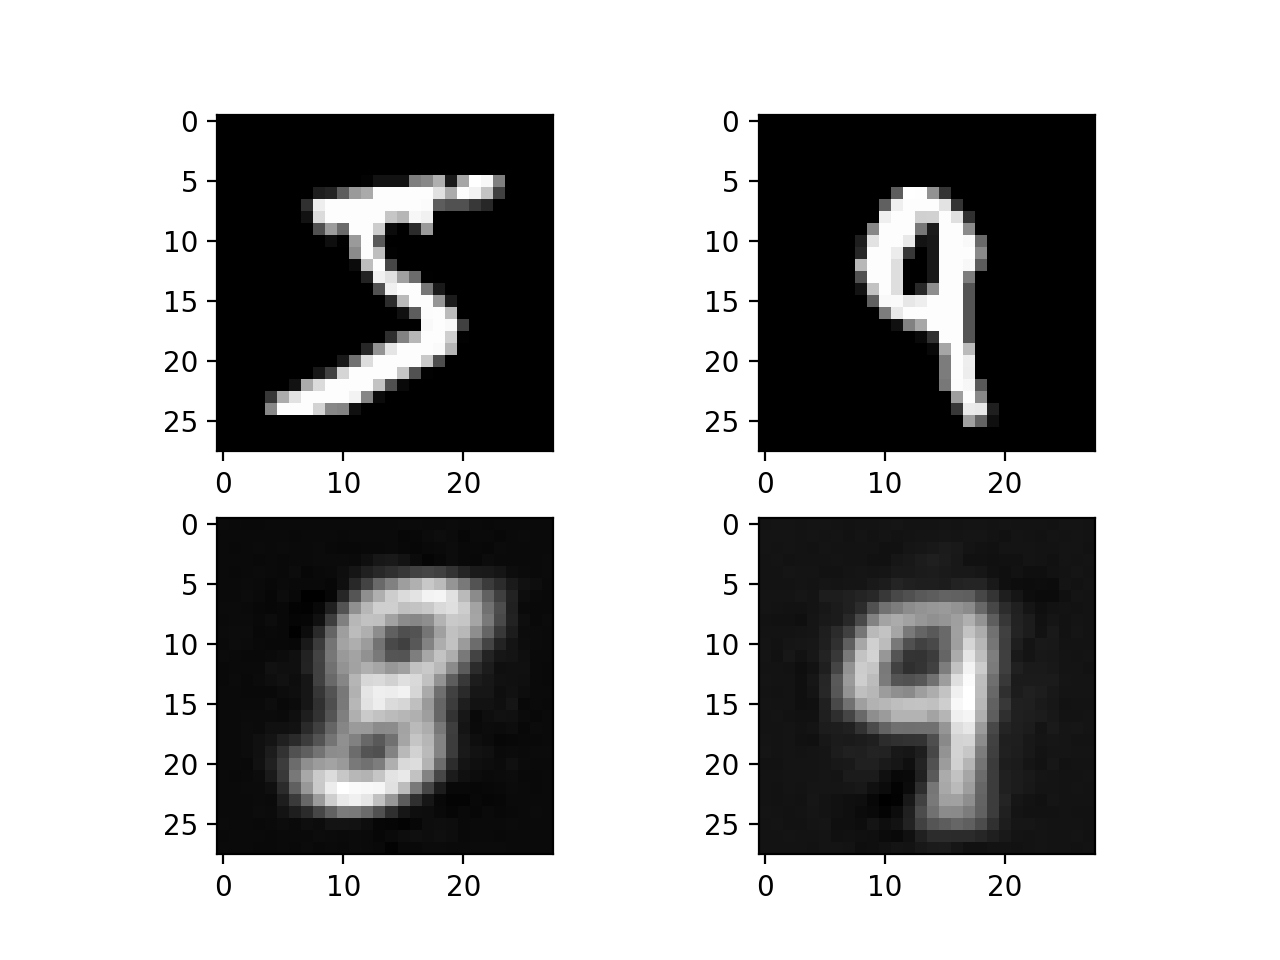

In [55]:
out_1 = np.squeeze(out_1).reshape(28,28)
out_2 = np.squeeze(out_2).reshape(28,28)
in_1 = x_train[0:1].reshape(28,28)
in_2 = x_train[46000:46001].reshape(28,28)

plt.subplot(221)
plt.imshow(in_1, cmap='gray')

plt.subplot(222)
plt.imshow(in_2, cmap='gray')

plt.subplot(223)
plt.imshow(out_1, cmap='gray')

plt.subplot(224)
plt.imshow(out_2, cmap='gray')

plt.show()


In [57]:
print p2b1.get_activations(mol_AE_model, 5, X[0:1])
print p2b1.get_activations(mol_AE_model, 5, X[46000:46001])

[array([[[ 0.        ,  0.        ,  0.79080653,  0.        ,  0.60760969,
          0.        ,  0.        ,  1.00268686]]], dtype=float32)]
[array([[[ 0.        ,  0.        ,  0.36583275,  0.        ,  0.38944611,
          0.        ,  0.0830877 ,  0.1071839 ]]], dtype=float32)]
